In [1]:
import galarp as grp
from galarp import InterpolatedStrengthWind, InterpolatedDensity

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import animation

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter


import cProfile

# Full dynamic shadowing

Shadowing occurs in ram pressure events when the disk (and other material) "gets in the way" of the ram pressure wind.
It manifests as a reduction of the wind downstream, as clouds work to limit the wind strength over time.

Examples of why this is important:

1. Face-on wind shadows have a higher *volume* than edge-on wind shadows. However, edge-on shadows must be **stronger**,
as the wind is passing through a higher column density of gas.


### How we do it

1. Apply a rotation matrix to our current particle distribution to align the particles with what the wind "sees"

2. Bin the particles by taking a 2D histogram along the wind's line of sight.

3. Determine the shadow using the clouds' z-positions (distance along LOS), using cumulative distribution functions.

This gives us a list of damping values for each cloud, without requiring us to rotating anything back into the original
frame.

In [11]:
orbits = grp.OrbitContainer.load("temp/orbits_JZ_dup.grp")

x,y,z, vx, vy, vz = grp.get_orbit_data(orbits.data, transposed=False)

wind = grp.LorentzianWind(inclination=np.deg2rad(45), strength=800 * u.km/u.s,
                            t0=300*u.Myr, width=200*u.Myr, units=galactic)


In [3]:
def plot_grid(axis, ybins, zbins):
    yrange = np.min(ybins), np.max(ybins)
    zrange = np.min(zbins), np.max(zbins)

    for i in range(len(ybins)):
        axis.plot([ybins[i], ybins[i]], [zrange[0], zrange[1]], color="black", alpha=0.5)
    for i in range(len(zbins)):
        axis.plot([yrange[0], yrange[1]], [zbins[i], zbins[i]], color="black", alpha=0.5)


def observed_minor_axis(a, b, inc):
    """ Estimate the observed axial ratio of a disk given the intrinsic axial ratio and inclination.
        From Holmberg (1958): https://ui.adsabs.harvard.edu/abs/1958MeLu2.136....1H/abstract

    Args:
        x (float): Size of disk intended to be measured
        a (_type_): Intrinsic major axis
        b (_type_): Intrinsic minor axis
        inc (_type_): Inclination of the disk

    Returns:
        float: _description_
    """
    disk_axial_ratio = b/a

    return a * (np.cos(inc) **2 * (1 - disk_axial_ratio**2) + disk_axial_ratio**2) ** 0.5

In [4]:
pot = orbits.metadata["POTENTIAL"]
a_disk, b_disk = 2 * pot["gas"].parameters["a"].value, 2 * pot["gas"].parameters["b"].value
print(a_disk, b_disk, observed_minor_axis(a_disk, b_disk, np.deg2rad(45)))

7.5 1.5 5.408326913195984


In [43]:
class DynamicShadow:

    def __init__(self, wind, a_disk=20, b_disk=2,
                  rho=grp.Density(1e-26 * u.g / u.cm ** 3), 
                 tau_wind=1 * u.Myr, masses=None, radii=None, **kwargs):
        self.wind = wind
        self.rho = rho

        self.masses = masses
        self.radii = radii * u.pc

        self.shadow_name = "Dynamic"

        self.a_disk = a_disk
        self.y_range = kwargs.get("y_range", (-self.a_disk, self.a_disk))
        
        self.b_disk = observed_minor_axis(a_disk, b_disk, wind.inclination)
        self.z_range = kwargs.get("z_range", (-self.b_disk, self.b_disk))
        
        self.n_bins = kwargs.get("n_bins", 20)

        self.L_bin = (self.y_range[1] - self.y_range[0]) / self.n_bins * u.kpc
        self.W_bin = (self.z_range[1] - self.z_range[0]) / self.n_bins * u.kpc

        self.A_bin = self.L_bin * self.W_bin
        self.tau_wind = tau_wind

        self.x_range = kwargs.get("x_range", (-20, 50))
        self.n_bins_wind_direction = kwargs.get("n_bins_wind_direction", 101)

        self.debug = kwargs.get("debug", False)
        self.interps = []


    def evaluate(self, q, p, t):
        """
        Evaluate the shadowing effect on particles dynamically, by rotating particles to the wind-frame of reference
        and then computing line-of sight depths.

        NOTE: In the wind frame, the Y-Z plane is what the wind "sees", and the X-axis is the distance along the
        wind direction.

        Parameters:
        - q: numpy array, shape (3, N)
            Array of particle positions.
        - t: float
            Time parameter (Redundant for this shadow, but might be useful if we implement a changing wind inclination).

        Returns:
        - shadowing: numpy array, shape (N,)
            Array of shadowing values for each particle.
        """

        q, p = q.T, p.T
    
        # STEP 1: Rotate the particles to the wind frame    

        xyz_rotated = grp.rotate_yaxis(q, beta=np.pi/2 - self.wind.inclination)
        xyz_rotated_T = xyz_rotated.T
        v_xyz_rotated = grp.rotate_yaxis(p, beta=np.pi/2 - self.wind.inclination)

        v_wind = np.sqrt(np.sum(wind.evaluate(t) ** 2)) * u.kpc / u.Myr

        shadowing = np.ones(len(q[0]))

        # STEP 2: Bin the particles along the y-z axis to get distribution along wind's line of sight
        # Create bins along the y and z axis
        y_bins = np.linspace(self.y_range[0], self.y_range[1], self.n_bins + 1)
        z_bins = np.linspace(self.z_range[0], self.z_range[1], self.n_bins + 1)

        L_slab = self.tau_wind * v_wind        
        A_clouds = np.pi * self.radii ** 2

        # This is the momentum deposited by the slab into each cloud
        # (p_dep / p_slab) = 2(1 + R_cl/L_slab)(1 - v_x/v_wind)(A_cloud/A_slab)
        normalized_p = 2 * (1 + self.radii / L_slab) 
        normalized_p *= (A_clouds / self.A_bin).cgs * (1 - v_xyz_rotated[0] * u.km / u.s / v_wind)
        
        # Bin particles along y-z axis
        y_bin_indices = np.digitize(xyz_rotated[1], y_bins)
        z_bin_indices = np.digitize(xyz_rotated[2], z_bins)

        # Get particles in the bin, and take only the z component
        # We take a cumulative sum of the histogram to get the integrated number of particles at each distance
        for i in range(self.n_bins):
            for j in range(self.n_bins):
                
                # Determine which particles are in this current bin              
                in_bin = np.bitwise_and(y_bin_indices == i + 1, z_bin_indices == j + 1)

                particles_in_bin = xyz_rotated_T[in_bin].T[0]     # Take x component of the rotated particles in bin
                sorted_indices = np.argsort(particles_in_bin)     # Sort the particles by x component
                
                if len(sorted_indices) == 0:
                    continue
                
                cum_p = np.cumsum(normalized_p[sorted_indices])
                cum_p = 1 - np.clip(cum_p, 0.5, 1)

                interp = interp1d(particles_in_bin[sorted_indices], cum_p, kind="linear", 
                                  fill_value=1, bounds_error=False, assume_sorted=True)

                # # Apply shadowing to the particles in this bin
                shadowing[in_bin] = interp(xyz_rotated_T[in_bin].T[0])
                
                if self.debug:
                    interp = interp1d(particles_in_bin[sorted_indices], 1 - cum_p, kind="linear", 
                                  fill_value=1, bounds_error=False, assume_sorted=True)
                    self.interps.append({"i": i, "j": j, "interp": interp})



        return shadowing


    def debug_evaluate(self, q, p, t, **kwargs):
        shadowing = self.evaluate(q, p, t)
        xyz_rotated = grp.rotate_yaxis(q.T, beta=np.pi/2 - self.wind.inclination)
        v_xyz_rotated = grp.rotate_yaxis(p.T, beta=np.pi/2 - self.wind.inclination)


        size = kwargs.get("size", 1)

        outname = kwargs.get("outname", None)
        cmap = kwargs.get("cmap", "magma")

        fig, ax = plt.subplots(1, 3, figsize=(12, 5))

        m1 = ax[0].scatter(xyz_rotated[0], xyz_rotated[1], c=shadowing, cmap=cmap, s=size)
        ax[0].set(xlabel="X [kpc]", ylabel="Y [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        m2 = ax[1].scatter(xyz_rotated[0], xyz_rotated[2], c=shadowing, cmap=cmap, s=size)
        ax[1].set(xlabel="X [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        m3 = ax[2].scatter(xyz_rotated[1], xyz_rotated[2], c=shadowing, cmap=cmap, s=size)
        ax[2].set(xlabel="Y [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))

        plot_grid(ax[2], 
                  np.linspace(self.y_range[0], self.y_range[1], self.n_bins + 1), 
                  np.linspace(self.z_range[0], self.z_range[1], self.n_bins + 1))

        plt.colorbar(mappable=m1, ax=ax[0], label="Wind Strength", orientation="horizontal", location="top")
        plt.colorbar(mappable=m2, ax=ax[1], label="Wind Strength", orientation="horizontal", location="top")
        plt.colorbar(mappable=m3, ax=ax[2], label="Wind Strength", orientation="horizontal", location="top")

        plt.tight_layout()
        if outname is not None:
            plt.savefig(outname, dpi=kwargs.get("dpi", 200))
            plt.close()


sigmas = np.random.randint(6, 40, 10000)        
masses = np.random.uniform(1e5, 1e6, 10000)
radii = np.random.uniform(20, 60, 10000)


depth = 5e10
inc = 65
index = 310
xyz = np.array([x[index], y[index], z[index]])
v_xyz = np.array([vx[index], vy[index], vz[index]])

for n_bin in [1, 5, 10, 20, 40, 50]:

    wind = grp.LorentzianWind(inclination=np.deg2rad(inc), strength=800 * u.km/u.s,
                            t0=300*u.Myr, width=200*u.Myr, units=galactic)
    shadow = DynamicShadow(wind, tau_wind=20 * u.Myr,
                           a_disk=a_disk, b_disk=b_disk,
                            masses=masses, radii=radii, 
                            #y_range=(-10, 10), z_range=(-10, 10), 
                            n_bins=n_bin, debug=False)
    shadowing = shadow.evaluate(xyz.T, v_xyz.T, 0)

    shadow.debug_evaluate(xyz.T, v_xyz.T, 0, outname=f"figures/dynamicshadows/shadowing_{index}_{inc}_{n_bin}.png", 
                          size=0.5, cmap=cmap, dpi=200)
    
    #%timeit shadow.evaluate(xyz.T, v_xyz.T, 0)

    # xs = np.linspace(-20, 50, 100)

    # img = np.ones((shadow.n_bins, shadow.n_bins)) * np.inf


    # fig, ax = plt.subplots(1, 2)

    # for interp_obj in shadow.interps:
    #     i, j, interp = interp_obj["i"], interp_obj["j"], interp_obj["interp"]
    #     img[j, i] = np.nanmin(interp(xs))
    #     ax[1].plot(xs, interp(xs), c="black", alpha=0.1)

    # mappable = ax[0].imshow(img)
    # plt.colorbar(mappable=mappable, ax=ax[0], orientation="horizontal", location="top")
    # plt.savefig(f"temp/shadowing_{n_bin}.png", dpi=200)

# cProfile.run("shadow.evaluate(xyz.T, v_xyz.T, 0)")



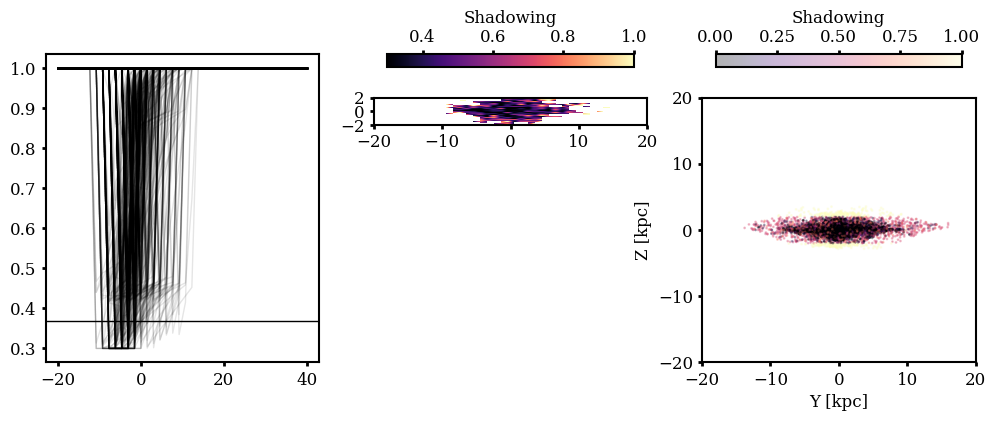

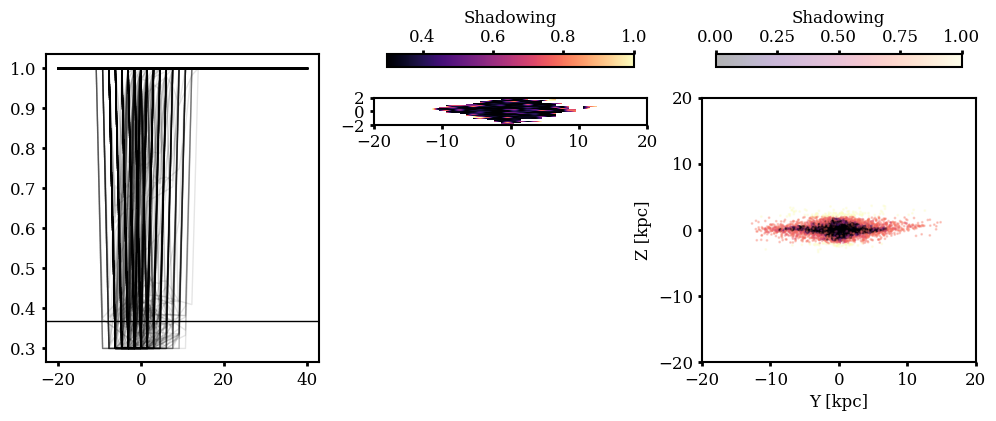

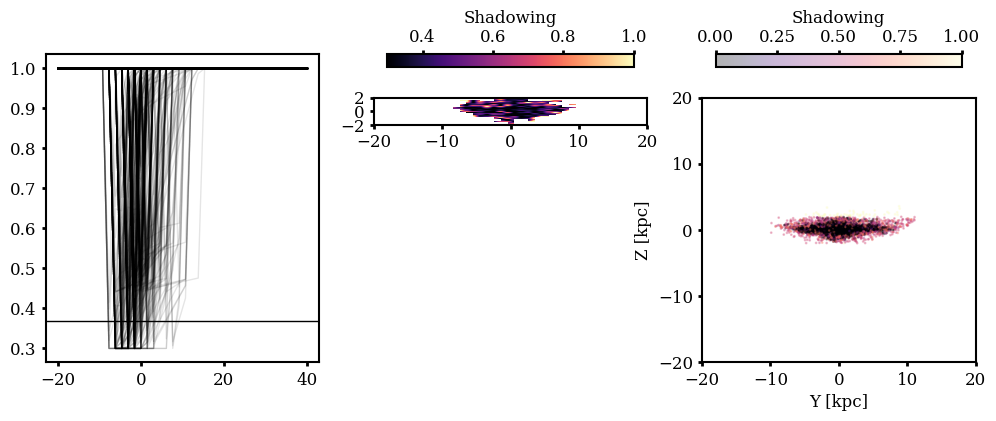

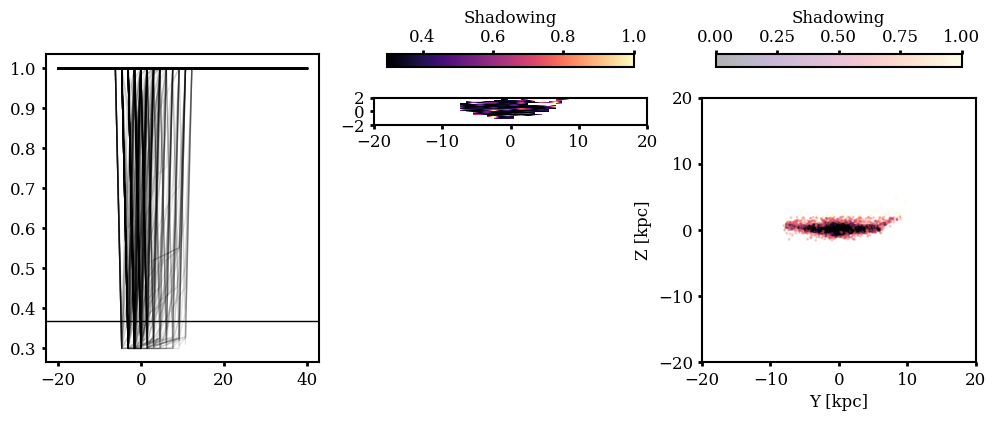

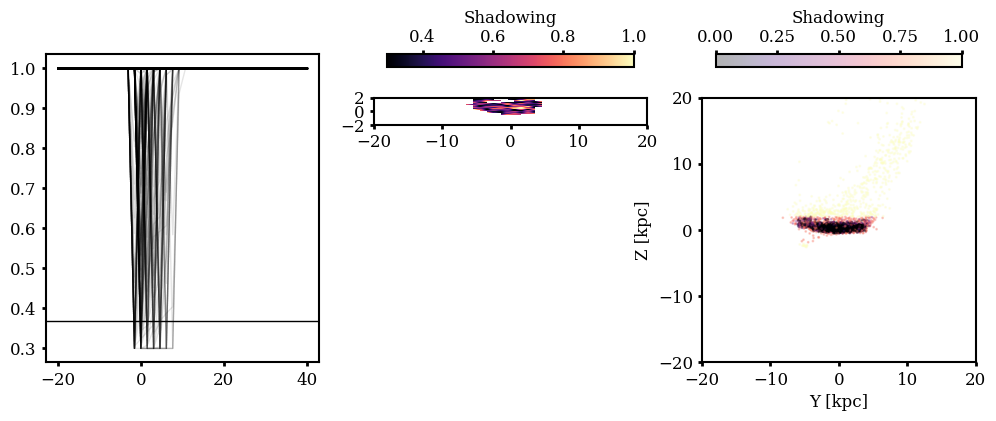

In [41]:
sigmas = np.random.randint(6, 40, 10000)        
masses = np.random.uniform(1e5, 1e6, 10000)
radii = np.random.uniform(20, 60, 10000)


depth = 5e10
inc = 90
for index in np.linspace(50, 400, 5).astype(int):
    xyz = np.array([x[index], y[index], z[index]])
    v_xyz = np.array([vx[index], vy[index], vz[index]])


    wind = grp.LorentzianWind(inclination=np.deg2rad(inc), strength=800 * u.km/u.s,
                            t0=300*u.Myr, width=200*u.Myr, units=galactic)

    shadow = DynamicShadow(wind, depth=depth, n_bins=40, debug=True, masses=masses, radii=radii, 
                           tau_wind=5 * u.Myr)
    shadowing = shadow.evaluate(xyz.T, v_xyz.T, 0)
    #shadow.debug_evaluate(xyz.T, 0, outname=f"figures/shadowing_new/shadow_{index}_{depth}_{inc:.0f}.png", cmap="magma")

    img = np.ones((shadow.n_bins, shadow.n_bins)) * np.inf

    samples_wind_dir = np.linspace(-20, 40, shadow.n_bins)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    dropoff = 1 / np.e
    for obj in shadow.interps[:]:
        i, j, interp = obj["i"], obj["j"], obj["interp"]

        samples = interp(samples_wind_dir)

        sample_depth = samples_wind_dir[np.argmax(samples < dropoff)]

        # img[j, i] = np.nanmin(samples)
        img[j, i] = np.nanmin(samples)

        ax[0].plot(samples_wind_dir, samples, c="black", alpha=0.1)
    
    ax[0].axhline(dropoff)
    
    mappable = ax[1].imshow(img, cmap="magma", origin="lower", extent=[*shadow.y_range, *shadow.z_range])
    # ax[0].set_xticks(np.linspace(0, 40, 5), np.linspace(*shadow.y_range, 5))
    # ax[0].set_yticks(np.linspace(0, 40, 5), np.linspace(*shadow.z_range, 5))
    
    xyz_rotated = grp.rotate(xyz, alpha=0, beta=0)

    scat = ax[2].scatter(xyz_rotated[1], xyz_rotated[2], c=shadowing, cmap="magma", s=1, alpha=0.3)
    ax[2].set(xlabel="Y [kpc]", ylabel="Z [kpc]", xlim=(-20, 20), ylim=(-20, 20))
    
    plt.colorbar(mappable=mappable, ax=ax[1], label="Shadowing", orientation="horizontal", 
                 location="top", pad=0.1, fraction=0.04)
    plt.colorbar(mappable=scat, ax=ax[2], label="Shadowing", orientation="horizontal", 
                 location="top", pad=0.1, fraction=0.04)

    plt.show()

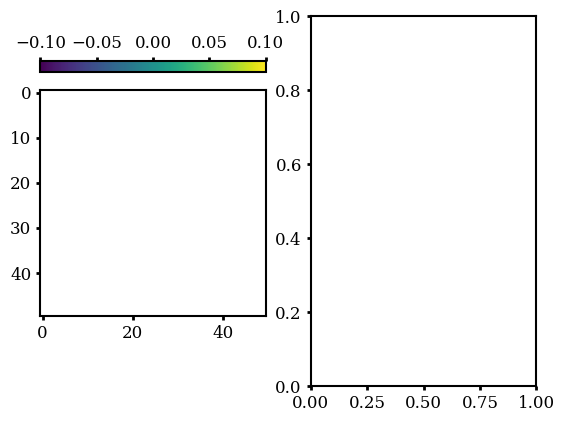

In [6]:
xs = np.linspace(-20, 50, 100)

img = np.ones((shadow.n_bins, shadow.n_bins)) * np.inf

fig, ax = plt.subplots(1, 2)

for interp_obj in shadow.interps:
    i, j, interp = interp_obj["i"], interp_obj["j"], interp_obj["interp"]
    img[j, i] = np.nanmin(interp(xs))
    ax[1].plot(xs, interp(xs), c="black", alpha=0.1)

mappable = ax[0].imshow(img)
plt.colorbar(mappable=mappable, ax=ax[0], orientation="horizontal", location="top")



## Testing sims with the dynamic shadow

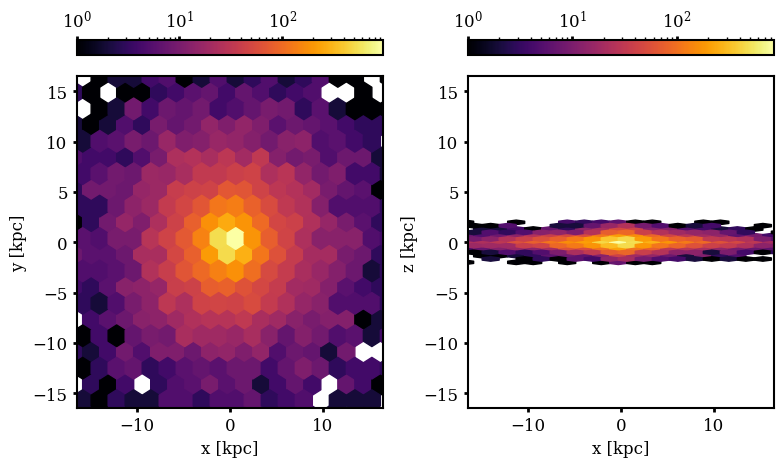

In [8]:
rb2006_satellite = grp.builtins.RB2006_Satellite()

mass_profile = grp.gen_mass_profile(rb2006_satellite)

particles = grp.ParticleSet(particles=grp.ParticleDistribution.from_file("temp/positions_RB.npy"))
particles.generate(mass_profile=mass_profile)
particles.particles.plot_positions(gridsize=30)



In [44]:
orbit_containers = []
incs = [0, 30, 60, 75, 90]

for inclination in incs:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination)

    shadow = DynamicShadow(rb2006_wind, 
                           a_disk=a_disk, b_disk=b_disk,
                           masses = np.random.uniform(1e5, 1e6, 10000), 
                           radii=np.random.uniform(20, 60, 10000),
                           n_bins=20)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow,)

    orbits = sim.run(particles, integration_time=1200 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers.append(orbits)

100%|██████████| 239/239 [00:39<00:00,  5.99it/s]


In [12]:
for i, inclination in enumerate(incs):
    print(i, inclination)
    grp.animated_hexbin_plot(orbit_containers[i], outname=f"figures/rb2006_dynamic_shadow_{inclination}_lowstrength.gif", 
                             cmap=cmap, n_frames=200)

0 0
1 30
2 60
3 75
4 90


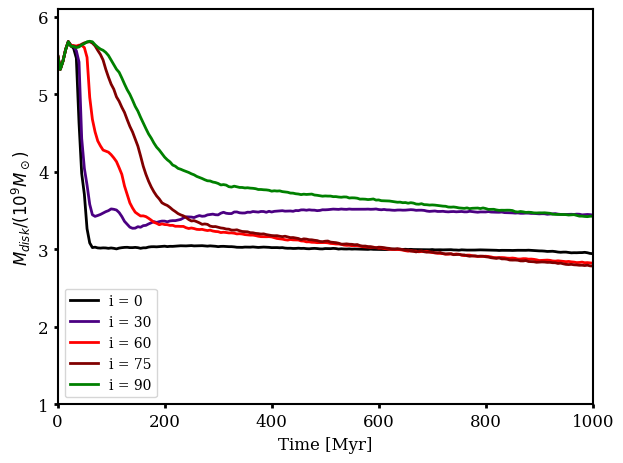

In [42]:
def Mdisk(orbits, rmax = 27 * u.kpc, thickness=1 * u.kpc, **kwargs):
    x,y,z, vx, vy, vz = orbits.get_orbit_data(transposed=False)

    r = np.sqrt(x**2 + y**2)

    r = np.sqrt(x**2 + y**2 + z**2)

    in_disk = np.logical_and(r < rmax.value, np.abs(z) < thickness.value)
    #in_disk = r < rmax.value


    evol = np.sum(in_disk, axis=1) * orbits.metadata["M_CLOUD"].to(u.Msun).value
    
    return orbits.data.t, evol

incs = [0, 30, 60, 75, 90]


colors = ["black", "indigo", "red", "maroon", "green"]

for i, container in enumerate(orbit_containers):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, color=colors[i], lw=2, label=f"i = {incs[i]}")

plt.xlim(0, 1000)
plt.ylim(1, 6.1)

plt.ylabel("$M_{disk} / (10^9 M_\odot)$")
plt.xlabel("Time [Myr]")

plt.legend(fontsize=10, loc="lower left")
plt.tight_layout()
plt.savefig("figures/rb2006_dynamic_shadow_diskmass_evolution.png", dpi=200)

In [39]:
for i, orbit_container in enumerate(orbit_containers):
    grp.k3d_plot([orbit_container], outname=f"temp/rb2006_dynamic_{incs[i]}.html")

AttributeError: 'InterpolatedStrengthWind' object has no attribute 'vector'

In [34]:
orbit_containers_around_30 = []
incs_around_30 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

for inclination in incs_around_30:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination)

    shadow = DynamicShadow(rb2006_wind, masses = np.random.uniform(1e5, 1e6, 10000), n_bins=20, depth=5e9)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers_around_30.append(orbits)



TypeError: unsupported operand type(s) for *: 'NoneType' and 'Unit'

/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_20300/638382909.py:4: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)


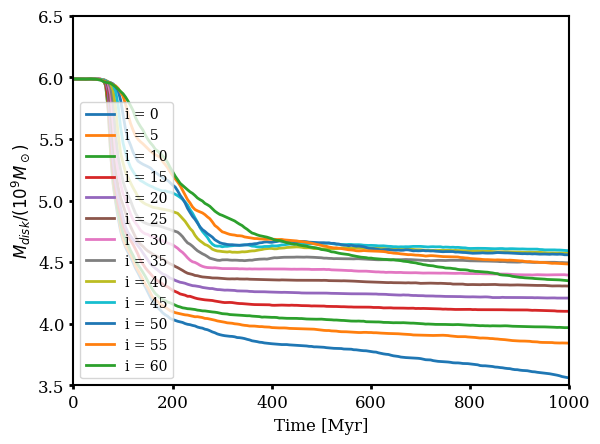

In [41]:
for i, container in enumerate(orbit_containers_around_30):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, lw=2, label=f"i = {incs_around_30[i]}")

plt.ylim(3.5, 6.5)
plt.xlim(0, 1000)
plt.legend(fontsize=10)
plt.xlabel("Time [Myr]")
plt.ylabel("$M_{disk} / (10^9 M_\odot)$")

plt.savefig("figures/rb2006_dynamic_shadow_diskmass_evolution_around_30.png", dpi=200)

In [9]:
orbit_containers_around_30_strongwind = []
incs_around_30 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
peak=1500
for inclination in incs_around_30:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination, peak= 1500)

    shadow = DynamicShadow(rb2006_wind, masses = np.random.uniform(1e5, 1e6, 10000), n_bins=20, depth=5e9)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers_around_30_strongwind.append(orbits)


100%|██████████| 399/399 [00:36<00:00, 10.79it/s]


/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_37965/638382909.py:4: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2)


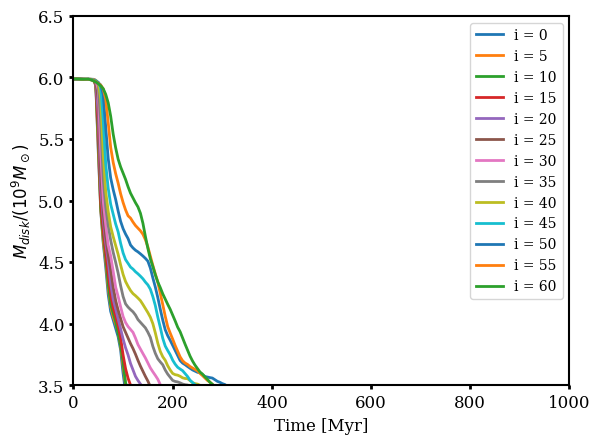

In [13]:
peak=1500

for i, container in enumerate(orbit_containers_around_30_strongwind):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, lw=2, label=f"i = {incs_around_30[i]}")

plt.ylim(3.5, 6.5)
plt.xlim(0, 1000)
plt.legend(fontsize=10)
plt.xlabel("Time [Myr]")
plt.ylabel("$M_{disk} / (10^9 M_\odot)$")

plt.savefig(f"figures/rb2006_dynamic_shadow_diskmass_evolution_around_30_{peak}.png", dpi=200)

In [17]:
orbit_containers_around_30_strongwind = []
incs_around_30 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
peak=1100
for inclination in incs_around_30:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination, peak= peak)

    shadow = DynamicShadow(rb2006_wind, masses = np.random.uniform(1e5, 1e6, 10000), n_bins=20, depth=5e9)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers_around_30_strongwind.append(orbits)

100%|██████████| 399/399 [00:39<00:00, 10.20it/s]


/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_37965/638382909.py:4: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2)


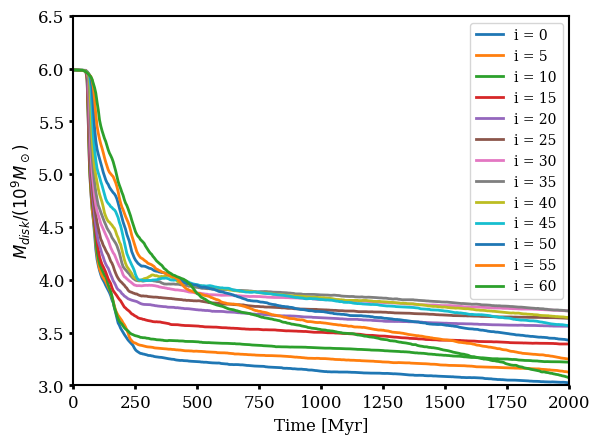

In [21]:
for i, container in enumerate(orbit_containers_around_30_strongwind):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, lw=2, label=f"i = {incs_around_30[i]}")

plt.ylim(3, 6.5)
plt.xlim(0, 2000)
plt.legend(fontsize=10)
plt.xlabel("Time [Myr]")
plt.ylabel("$M_{disk} / (10^9 M_\odot)$")

plt.savefig(f"figures/rb2006_dynamic_shadow_diskmass_evolution_around_30_{peak}.png", dpi=200)

In [ ]:
orbit_containers_lorentzian = []
incs = [0, 15, 30, 60, 90]

for inclination in incs:

    wind = grp.LorentzianWind(t0=500*u.Myr, width=500*u.Myr, units=galactic)
    wind.init_from_inc(inclination=np.deg2rad(inclination), strength=800 * u.km/u.s)

    shadow = DynamicShadow(wind, masses = np.random.uniform(1e5, 1e6, 10000), n_bins=40)

    sim = grp.RPSim(wind=wind, potential=rb2006_satellite, shadow=shadow)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers_lorentzian.append(orbits)

10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:12<00:00,  5.51it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:27<00:00,  4.55it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:38<00:00,  4.04it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:41<00:00,  3.93it/s]


10.0 solMass / pc2 10000
10000


100%|██████████| 399/399 [01:49<00:00,  3.64it/s]


/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_24863/1816796554.py:4: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)


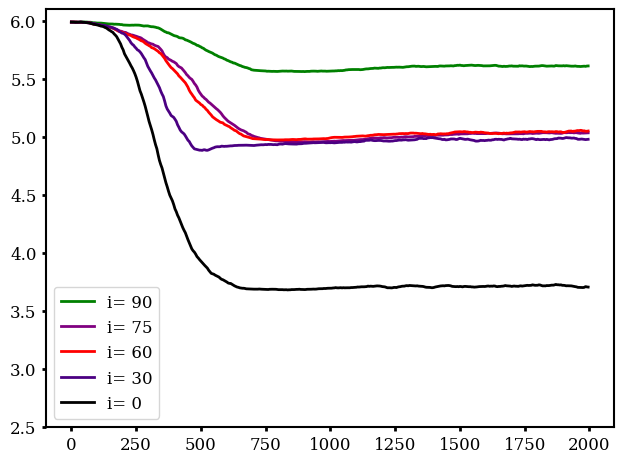

In [ ]:
for i, container in enumerate(orbit_containers_lorentzian):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, label=f"i= { 90 - incs[i]}", color=colors[i], lw=2)

plt.ylim(2.5, 6.1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def rstrip_rb2006(orbits, n_scanlines=12):
    x,y,z, *_ = orbits.get_orbit_data(transposed=False)

    r = np.sqrt(x**2 + y**2)
    thetas = np.arctan2(y, x)

    bins = np.linspace(0, 40, 100)
    areas = np.pi * (bins[1:]**2 - bins[:-1]**2)
    print(len(bins), len(areas))
    xs = np.arange(0, 100, 100)

    stripped_mins, stripped_maxes, stripped_means = [], [], []
    for i in range(0, len(x)):
        this_x, this_y = x[i], y[i]
        this_r = r[i]
        thetas = np.arctan2(this_y, this_x)

        stripped_vals = []
        for theta in np.arange(0, 360, 360 / n_scanlines):

            theta_rad = np.deg2rad(theta)
            delta_theta = 2 * np.pi / n_scanlines
            
            in_sector = np.logical_and(theta_rad < thetas, thetas < theta_rad + delta_theta)
            in_sector = np.logical_and(in_sector, np.logical_and(~np.isnan(this_r), this_r < 27))
            
            r_in_sector = this_r[in_sector]

            hist = np.histogram(r_in_sector, bins=bins)[0]
            hist = hist / areas
            this_stripped = np.argmax(hist < 0.1)

            stripped_vals.append(bins[this_stripped])

        stripped_vals = np.array(stripped_vals)
        stripped_mins.append(np.nanmin(stripped_vals))
        stripped_maxes.append(np.nanmax(stripped_vals))
        stripped_means.append(np.nanmean(stripped_vals))

    return np.array(stripped_mins), np.array(stripped_maxes), np.array(stripped_means)



/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_48811/933709529.py:4: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2)


100 99
100 99
100 99
100 99
100 99


(0.0, 1000.0)

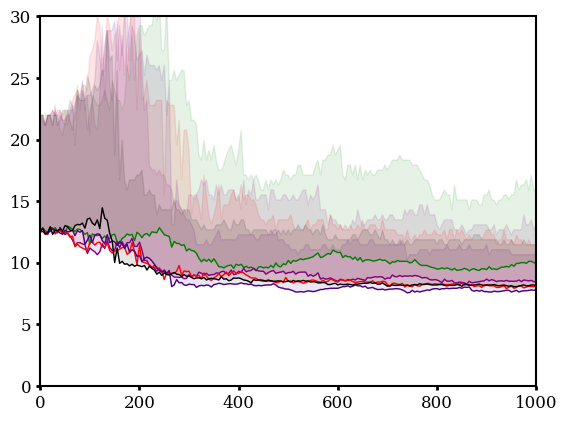

In [ ]:

floor = 5

for i, container in enumerate(orbit_containers):
    mins, maxes, medians = rstrip_rb2006(container)
    plt.plot(times, medians + floor, label=f"Inc: {incs[i]}", color=colors[i])
    plt.fill_between(times.value, medians + floor, maxes + floor, alpha=0.1, color=colors[i])
# plt.plot(times, medians, label="Mean")
# plt.fill_between(times.value, mins, maxes, alpha=0.5, label="Min-Max")

plt.ylim(0, 30)
plt.xlim(0, 1000)

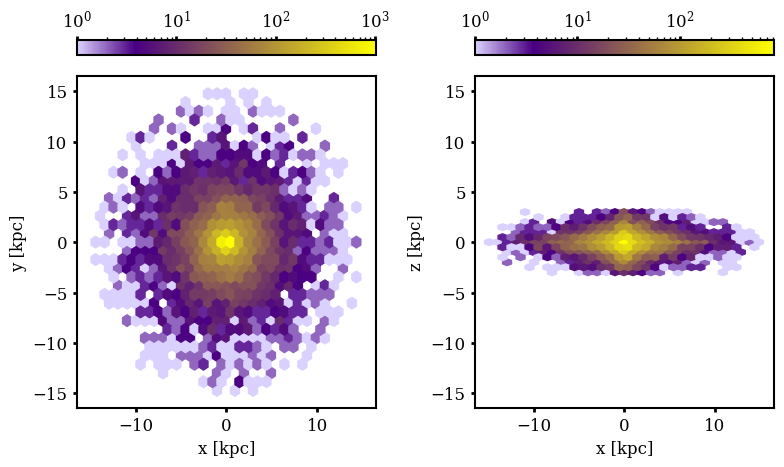

In [ ]:
jz_satellite = grp.builtins.JZ2023_Satellite()
mass_profile = grp.gen_mass_profile(jz_satellite)

particles = grp.ExponentialGrid(h_R=jz_satellite["gas"].parameters["a"],
                                h_z=jz_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions.npy")

particles.plot_density(cmap=cmap, gridsize=30)


In [ ]:
orbit_containers_jz = []
incs = [0, 15, 30, 60, 90]

for inclination in incs:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inclination)

    shadow = DynamicShadow(rb2006_wind, masses = np.random.uniform(1e5, 1e6, 10000), n_bins=40, depth=1e10)

    sim = grp.RPSim(wind=rb2006_wind, potential=jz_satellite, shadow=shadow)

    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)
    orbit_containers_jz.append(orbits)


for i, container in enumerate(orbit_containers_jz):
    times, evol = Mdisk(container)
    plt.plot(times, evol * 6 / 1e9, label=f"i= { 90 - incs[i]}", color=colors[i], lw=2)

plt.ylim(2.5, 6.1)
plt.legend()
plt.tight_layout()
plt.show()

10.0 solMass / pc2 10000
10000


 22%|██▏       | 86/399 [00:21<01:17,  4.01it/s]


KeyboardInterrupt: 

In [ ]:
for i, inclination in enumerate(incs):

    grp.animated_hexbin_plot(orbit_containers_jz[i], outname=f"figures/jz_dup/jz2023_dynamic_shadow_{inclination}.gif", 
                             cmap=cmap, n_frames=200)

/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5001: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(iy).astype(int)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5003: RuntimeWarning: invalid value encountered in cast
  iy2 = np.floor(iy).astype(int)
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:28: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5010: RuntimeWarning: overflow encountered in square
  d1 = (ix - ix1) ** 2 + 3.0 * (iy - iy1) ** 2
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5011: RuntimeWarning: overflow encountered in square
  d2 = (ix - ix2 - 0.5) ** 2 + 3.0 * (iy - iy2 - 0.5) ** 2
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:28: R

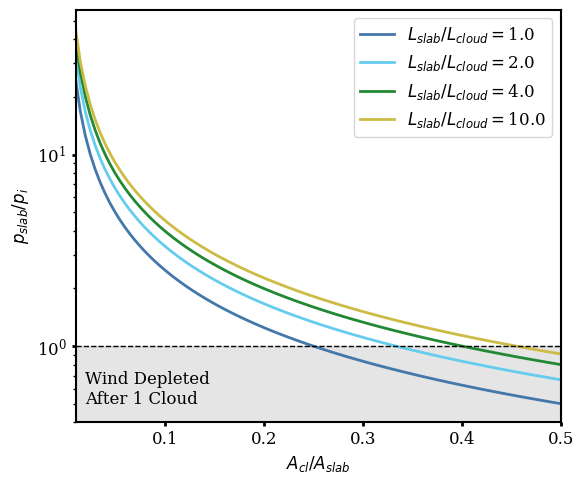

In [200]:
def norm_pi(norm_rcloud = 2, norm_Acloud=3, v_x = 0 * u.km / u.s, v_wind = 800 * u.km / u.s):
    return 2 * (1 + norm_rcloud) * (norm_Acloud) * (1 - v_x / v_wind)


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

norm_aclouds = np.linspace(0.01, 0.5, 100)

colors = grp.default_colors()

for i, norm_r_cloud in enumerate([1, 0.5, 0.25, 0.1]):     # This is the ratio of cloud radius to the slab length
    plt.plot(norm_aclouds, 1 / norm_pi(norm_Acloud=norm_aclouds, norm_rcloud=norm_r_cloud), 
                                    lw=2, color=colors[i],
                                   label="$L_{slab} / L_{cloud} =$" + f"{1 / norm_r_cloud :.1f}")

plt.axhline(1, color="black", ls="--")
plt.text(0.02, 0.5, "Wind Depleted\nAfter 1 Cloud", fontsize=12)
plt.xlabel("$A_{cl} / A_{slab}$")
plt.ylabel("$p_{slab} / p_{i}$")

plt.fill_between(norm_aclouds, 0, 1, color="black", alpha=0.1)

#plt.ylim(0, 5)
plt.xlim(min(norm_aclouds), max(norm_aclouds))
plt.yscale("log")
plt.legend(fontsize=12)
plt.tight_layout()

In [4]:
def plot_grid(ybins, zbins):
    yrange = np.min(ybins), np.max(ybins)
    zrange = np.min(zbins), np.max(zbins)

    for i in range(len(ybins)):
        plt.plot([ybins[i], ybins[i]], [zrange[0], zrange[1]], color="black", alpha=0.5)
    for i in range(len(zbins)):
        plt.plot([yrange[0], yrange[1]], [zbins[i], zbins[i]], color="black", alpha=0.5)



disk_a, disk_b = rb2006_satellite["gas"].parameters["a"], rb2006_satellite["gas"].parameters["b"]

xbins = np.linspace(-2* disk_a.value, 2 * disk_a.value, 20)
ybins = np.linspace(-2 * disk_b.value, 2 * disk_b.value, 20)

plt.figure(figsize=(6, 5))

plt.scatter(xyz[1], xyz[2], s=1)

plt.xlim(-15, 15)
plt.ylim(-15, 15)

plot_grid(xbins, ybins)


NameError: name 'rb2006_satellite' is not defined

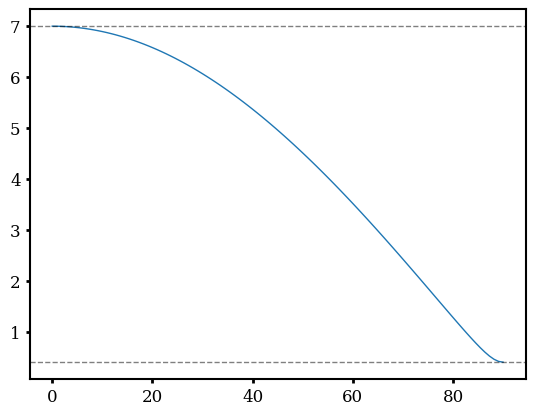

In [103]:

def observed_minor_axis(a, b, inc):
    """ Estimate the observed axial ratio of a disk given the intrinsic axial ratio and inclination.
        From Holmberg (1958): https://ui.adsabs.harvard.edu/abs/1958MeLu2.136....1H/abstract

    Args:
        x (float): Size of disk intended to be measured
        a (_type_): Intrinsic major axis
        b (_type_): Intrinsic minor axis
        inc (_type_): Inclination of the disk

    Returns:
        float: _description_
    """
    disk_axial_ratio = b/a

    return a * (np.cos(inc) **2 * (1 - disk_axial_ratio**2) + disk_axial_ratio**2) ** 0.5


disk_a, disk_b = rb2006_satellite["gas"].parameters["a"], rb2006_satellite["gas"].parameters["b"]


x = disk_a
thetas = np.linspace(0, np.pi/2, 100)

plt.plot(np.rad2deg(thetas), observed_minor_axis(disk_a, disk_b, thetas))

plt.axhline(disk_a.value, color="black", ls="--", alpha=0.5)
plt.axhline(disk_b.value, color="black", ls="--", alpha=0.5)


